In [22]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
from tensorflow import keras
from NNmodel import NNMultistepModel

In [23]:
# Downloading data 
dl_data = False

if dl_data:
    !python3 dataDownload.py

In [24]:
# Creating tidy data
!python3 createTidyData.py

In [25]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [26]:
# Hyper parameters for analysis
start_date_analysis = datetime.datetime(2020, 4, 1).date()

# Features in models 
features_models = ['is_hospitalized', 'is_covid']

# Wrangling LT data

In [27]:
d = pd.read_csv('data/tidy_data_LT.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= start_date_analysis]

# Leaving only the time series 
dLT = d[features_models]

# Saving the days list 
days = d.day

# Calculating the rolling mean for Lithuania data 
dLTmean = dLT.rolling(window=7).mean()

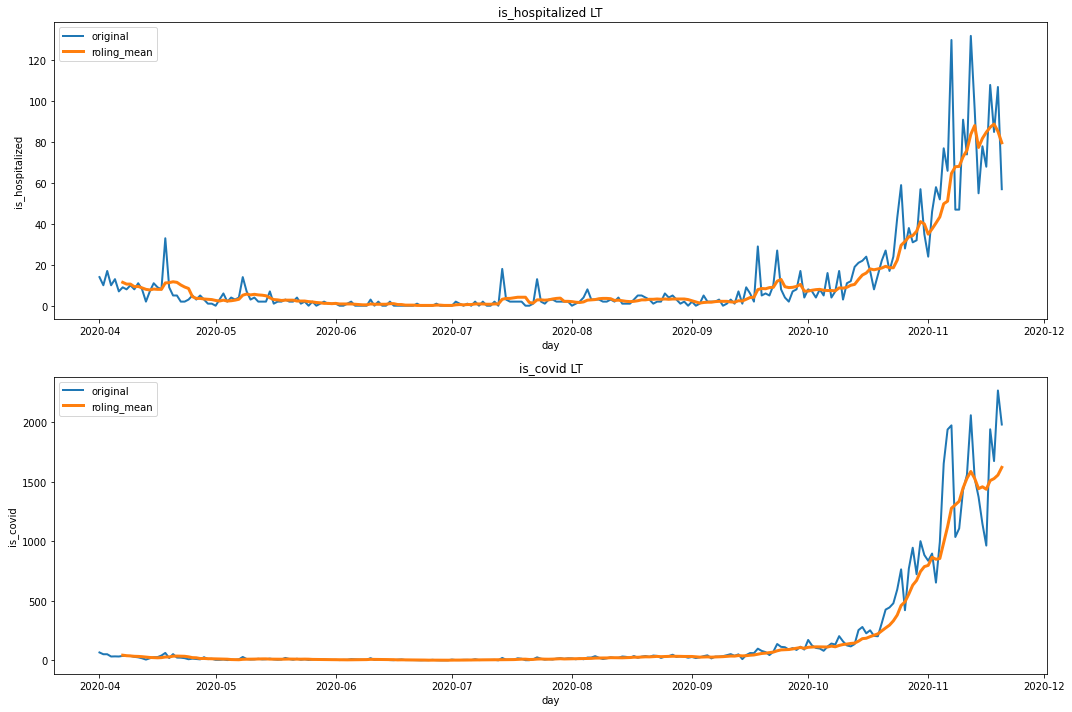

In [28]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = dLT.columns

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=d['day'], y=dLT[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=d['day'], y=dLTmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} LT')
        
plt.tight_layout()

# Wrangling Estonia data

In [29]:
d = pd.read_csv('data/tidy_data_EST.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= start_date_analysis]

# Leaving only the time series 
dEST = d[features_models]

# Saving the days list 
daysEST = d.day

# Calculating the rolling mean for Lithuania data 
dESTmean = dEST.rolling(window=7).mean()

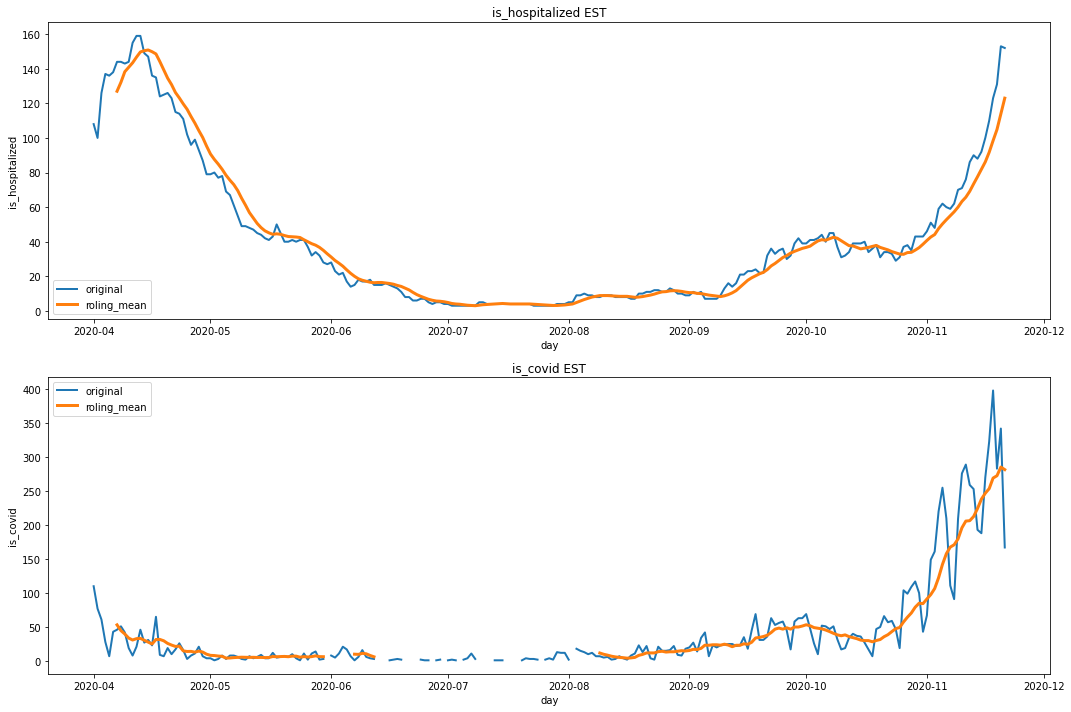

In [30]:
# Ploting some states
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = dEST.columns

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=daysEST, y=dEST[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=daysEST, y=dESTmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} EST')
        
plt.tight_layout()

# Wrangling US data 

In [31]:
dUS = pd.read_csv('data/tidy_data_US.csv')

# Sorting by date 
dUS['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dUS['day']]
dUS.sort_values('day', inplace=True)

# Leaving only the data since the second wave
dUS = dUS[dUS['day']>= start_date_analysis]

# Droping the date column
daysUS = dUS['day']
dUS = dUS[features_models]

# Getting the rolling mean 
dUSmean = dUS.rolling(window=7).mean()

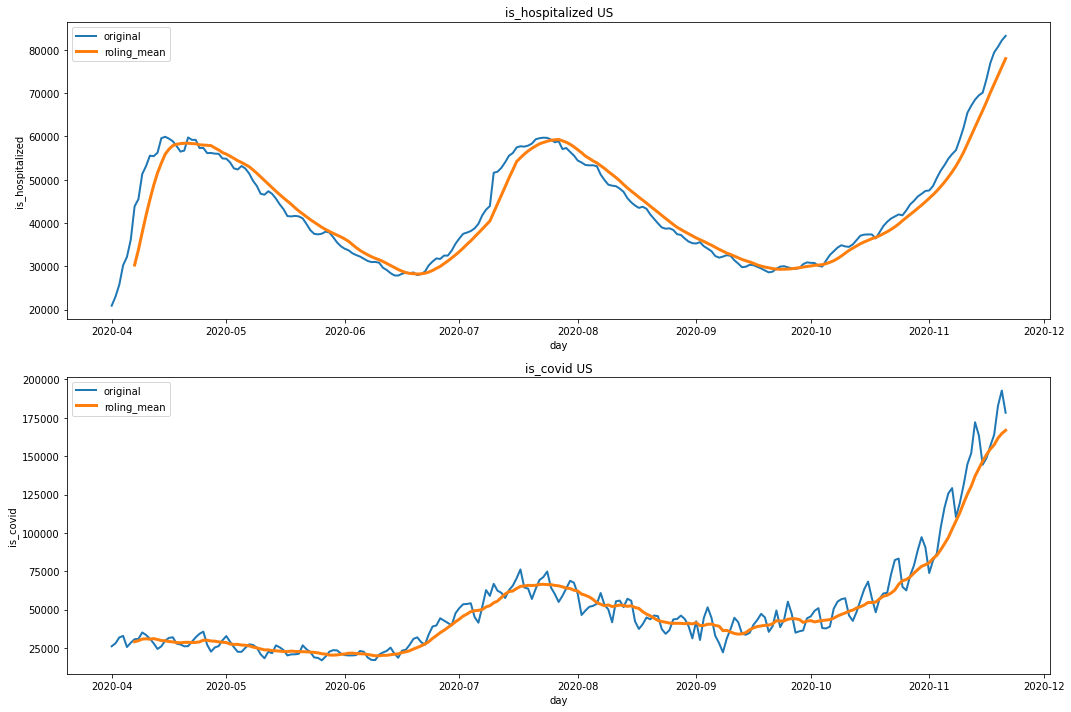

In [32]:
# Ploting some states
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = dUS.columns

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=daysUS, y=dUS[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=daysUS, y=dUSmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} US')
        
plt.tight_layout()

# Calculating percentage changes in all the datasets

In [33]:
# US data
dUS_pct = dUS.pct_change()
dUS_pct = dUS_pct.replace([np.inf, -np.inf], np.nan)
dUS_pct.fillna(0, inplace=True)    
    
# Dataset for Lithuania
dLT_pct = dLT.pct_change()
dLT_pct = dLT_pct.replace([np.inf, -np.inf], np.nan)
dLT_pct.fillna(0, inplace=True)

# Dataset for Estonia
dEST_pct = dEST.pct_change()
dEST_pct = dEST_pct.replace([np.inf, -np.inf], np.nan)
dEST_pct.fillna(0, inplace=True)

# Visualizing the data that will be modeled

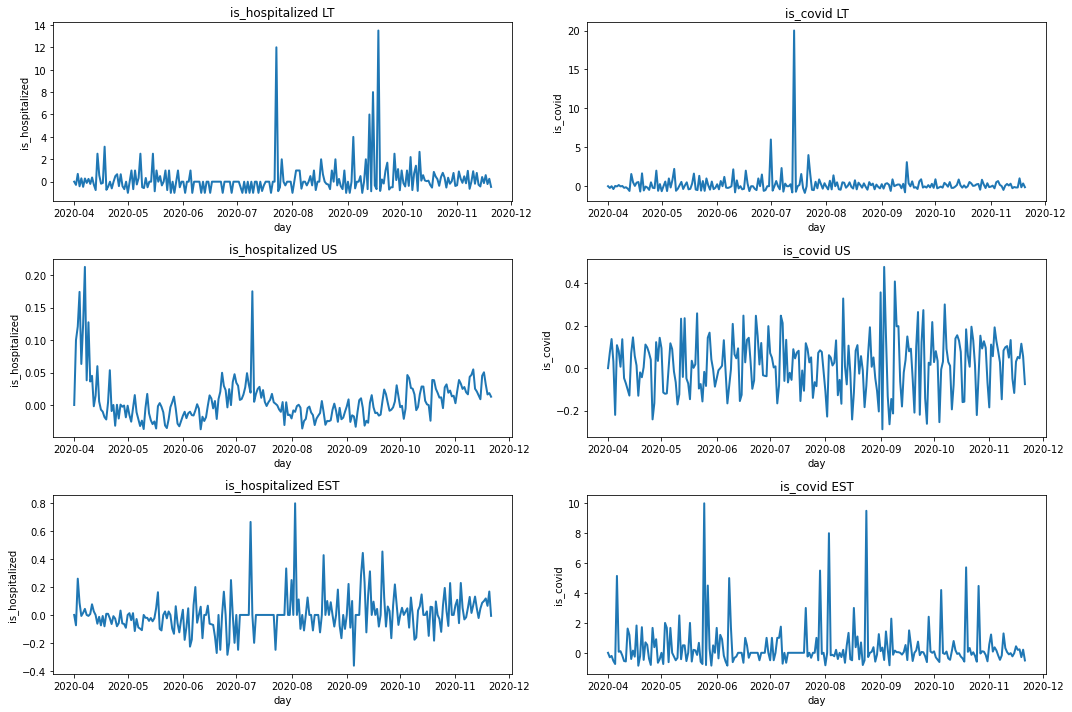

In [34]:
fig, axes = plt.subplots(
    nrows=3, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[0, i], x=days, y=dLT_pct[feature], linewidth=2)
    axes[0, i].set_title(f'{feature} LT')

for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[1, i], x=daysUS, y=dUS_pct[feature], linewidth=2)
    axes[1, i].set_title(f'{feature} US')    

    
for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[2, i], x=daysEST, y=dEST_pct[feature], linewidth=2)
    axes[2, i].set_title(f'{feature} EST')
    
plt.tight_layout()

# Creating the dataframes for training 

In [35]:
# Setting the hyper parameters 
# Defining the lag 
n_lag = 21

# Defining the steps ahead to forecast 
n_ahead = 7

# Number of features used in the model 
n_ft = dLT.shape[1]

In [36]:
Xus, Yus = create_X_Y_generalized(dUS_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
Xes, Yes = create_X_Y_generalized(dEST_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
Xlt, Ylt = create_X_Y_generalized(dLT_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)

X = np.concatenate([Xus, Xes, Xlt])
Y = np.concatenate([Yus, Yes, Ylt])

#X = np.concatenate([Xes, Xlt]) 
#Y = np.concatenate([Yes, Ylt])

In [37]:
# Defining the number of last n_ahead obs to keep in the validation set
n_val = 1

# All indexes 
ind = list(range(len(X)))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

# Extracting train and validation matrices for deep learning training
Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xval, Yval = X[val_idx], Y[val_idx]

print(f"Shape of the training feature matrix (series): {Xtrain.shape}")
print(f"Shape of the validation feature matrix (series): {Xval.shape}")
print(f"Shape of the target matrix: {Ytrain.shape}")
print(f"Shape of the validation target matrix: {Yval.shape}")

Shape of the training feature matrix (series): (619, 21, 2)
Shape of the validation feature matrix (series): (1, 21, 2)
Shape of the target matrix: (619, 7)
Shape of the validation target matrix: (1, 7)


In [38]:
# Creating the model object for validation 
modelVal = NNMultistepModel(
    X=Xtrain, 
    Y=Ytrain, 
    n_lag=n_lag, 
    n_ft=n_ft,
    n_outputs=n_ahead,
    Xval=Xval,
    Yval=Yval
)

In [39]:
print(f'Number of epochs: {modelVal.epochs}')
print(f'Number of neurons in LSMT layer {modelVal.n_layer}')
print(f'Learning rate: {modelVal.lr}')

Number of epochs: 600
Number of neurons in LSMT layer 32
Learning rate: 0.0001


In [40]:
modelVal.model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21, 2)]           0         
_________________________________________________________________
masking_1 (Masking)          (None, 21, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________


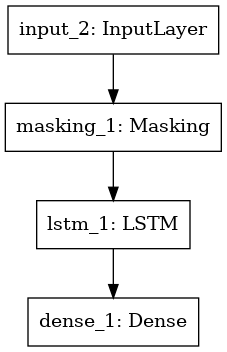

In [41]:
keras.utils.plot_model(modelVal.model)

In [42]:
history = modelVal.train()

Epoch 1/600
78/78 [==============================] - 1s 13ms/step - loss: 0.2858 - val_loss: 0.3451
Epoch 2/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2815 - val_loss: 0.3414
Epoch 3/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2794 - val_loss: 0.3400
Epoch 4/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2783 - val_loss: 0.3398
Epoch 5/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2776 - val_loss: 0.3396
Epoch 6/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2770 - val_loss: 0.3391
Epoch 7/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2766 - val_loss: 0.3386
Epoch 8/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2761 - val_loss: 0.3382
Epoch 9/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2758 - val_loss: 0.3377
Epoch 10/600
78/78 [==============================] - 1s 12ms/step - loss: 0.2754 - val_loss: 0.3372
Epoch 

78/78 [==============================] - 1s 10ms/step - loss: 0.2698 - val_loss: 0.3296
Epoch 83/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2698 - val_loss: 0.3294
Epoch 84/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2697 - val_loss: 0.3294
Epoch 85/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2697 - val_loss: 0.3296
Epoch 86/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2696 - val_loss: 0.3299
Epoch 87/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2696 - val_loss: 0.3296
Epoch 88/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2696 - val_loss: 0.3295
Epoch 89/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2695 - val_loss: 0.3295
Epoch 90/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2695 - val_loss: 0.3296
Epoch 91/600
78/78 [==============================] - 1s 10ms/step - loss: 0.2694 - val_loss: 0.3295
Epoc

78/78 [==============================] - 1s 9ms/step - loss: 0.2666 - val_loss: 0.3311
Epoch 163/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2667 - val_loss: 0.3309
Epoch 164/600
78/78 [==============================] - 1s 7ms/step - loss: 0.2666 - val_loss: 0.3313
Epoch 165/600
78/78 [==============================] - 0s 6ms/step - loss: 0.2666 - val_loss: 0.3306
Epoch 166/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2665 - val_loss: 0.3304
Epoch 167/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2664 - val_loss: 0.3301
Epoch 168/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2664 - val_loss: 0.3301
Epoch 169/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2663 - val_loss: 0.3314
Epoch 170/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2665 - val_loss: 0.3311
Epoch 171/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2664 - val_loss: 0.3301
Epoc

78/78 [==============================] - 0s 5ms/step - loss: 0.2624 - val_loss: 0.3281
Epoch 244/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2621 - val_loss: 0.3274
Epoch 245/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2619 - val_loss: 0.3283
Epoch 246/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2622 - val_loss: 0.3288
Epoch 247/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2617 - val_loss: 0.3264
Epoch 248/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2622 - val_loss: 0.3301
Epoch 249/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2617 - val_loss: 0.3268
Epoch 250/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2618 - val_loss: 0.3277
Epoch 251/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2636 - val_loss: 0.3279
Epoch 252/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2624 - val_loss: 0.3288
Epoc

78/78 [==============================] - 0s 5ms/step - loss: 0.2596 - val_loss: 0.3278
Epoch 325/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2587 - val_loss: 0.3257
Epoch 326/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2585 - val_loss: 0.3258
Epoch 327/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2594 - val_loss: 0.3252
Epoch 328/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2586 - val_loss: 0.3290
Epoch 329/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2609 - val_loss: 0.3244
Epoch 330/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2588 - val_loss: 0.3272
Epoch 331/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2583 - val_loss: 0.3250
Epoch 332/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2581 - val_loss: 0.3259
Epoch 333/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2583 - val_loss: 0.3263
Epoc

78/78 [==============================] - 0s 5ms/step - loss: 0.2558 - val_loss: 0.3241
Epoch 406/600
78/78 [==============================] - 0s 6ms/step - loss: 0.2558 - val_loss: 0.3261
Epoch 407/600
78/78 [==============================] - 1s 7ms/step - loss: 0.2559 - val_loss: 0.3230
Epoch 408/600
78/78 [==============================] - 0s 6ms/step - loss: 0.2568 - val_loss: 0.3253
Epoch 409/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2554 - val_loss: 0.3262
Epoch 410/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2565 - val_loss: 0.3215
Epoch 411/600
78/78 [==============================] - 0s 6ms/step - loss: 0.2562 - val_loss: 0.3283
Epoch 412/600
78/78 [==============================] - 1s 7ms/step - loss: 0.2586 - val_loss: 0.3220
Epoch 413/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2554 - val_loss: 0.3259
Epoch 414/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2563 - val_loss: 0.3233
Epoc

78/78 [==============================] - 0s 5ms/step - loss: 0.2547 - val_loss: 0.3266
Epoch 487/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2529 - val_loss: 0.3238
Epoch 488/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2526 - val_loss: 0.3255
Epoch 489/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2533 - val_loss: 0.3257
Epoch 490/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2525 - val_loss: 0.3232
Epoch 491/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2548 - val_loss: 0.3282
Epoch 492/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2528 - val_loss: 0.3230
Epoch 493/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2527 - val_loss: 0.3256
Epoch 494/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2542 - val_loss: 0.3250
Epoch 495/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2522 - val_loss: 0.3240
Epoc

78/78 [==============================] - 0s 5ms/step - loss: 0.2505 - val_loss: 0.3260
Epoch 568/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2509 - val_loss: 0.3262
Epoch 569/600
78/78 [==============================] - 1s 7ms/step - loss: 0.2504 - val_loss: 0.3244
Epoch 570/600
78/78 [==============================] - 1s 9ms/step - loss: 0.2520 - val_loss: 0.3266
Epoch 571/600
78/78 [==============================] - 1s 8ms/step - loss: 0.2498 - val_loss: 0.3238
Epoch 572/600
78/78 [==============================] - 0s 6ms/step - loss: 0.2509 - val_loss: 0.3285
Epoch 573/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2501 - val_loss: 0.3217
Epoch 574/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2521 - val_loss: 0.3290
Epoch 575/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2497 - val_loss: 0.3227
Epoch 576/600
78/78 [==============================] - 0s 5ms/step - loss: 0.2499 - val_loss: 0.3265
Epoc

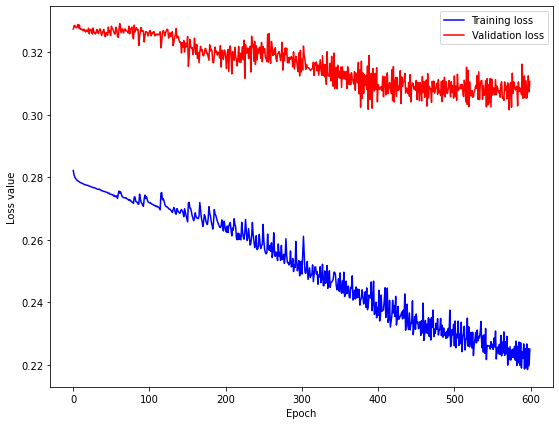

In [48]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [49]:
yhatval_abs = [x for x in modelVal.predict(Xval)][0]
yval_abs = [x for x in Yval][0]

fc = pd.concat([
    pd.DataFrame({'value': yval_abs, 'index': range(len(yval_abs)), 'type': 'original'}),
    pd.DataFrame({'value': yhatval_abs, 'index': range(len(yval_abs)), 'type': 'forecast'})
], axis=0)

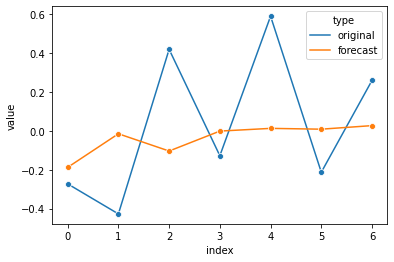

In [50]:
sns.lineplot(x='index', y='value', data=fc, hue='type', marker='o')
plt.show()

In [25]:
day_avg_real = np.mean(yval_abs)
day_avg_forecast = np.mean(yhatval_abs)

print(f"7 day average real: {day_avg_real * 100}%")
print(f"7 day average forecasted: {day_avg_forecast * 100}%")

7 day average real: 3.203742064036181%
7 day average forecasted: -5.736821889877319%


In [26]:
# Building the final model and forecasting
modelFinal = NNMultistepModel(
    X=X, 
    Y=Y, 
    n_lag=n_lag, 
    n_ft=n_ft,
    n_outputs=n_ahead
)

history = modelFinal.train()

Epoch 1/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2840
Epoch 2/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2815
Epoch 3/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2805
Epoch 4/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2799
Epoch 5/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2796
Epoch 6/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2794
Epoch 7/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2791
Epoch 8/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2790
Epoch 9/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2787
Epoch 10/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2785
Epoch 11/600
76/76 [==============================] - 0s 7ms/step - loss: 0.2783
Epoch 12/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2782
Epoch 13/600
76/76 [=================

76/76 [==============================] - 1s 8ms/step - loss: 0.2699
Epoch 103/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2695
Epoch 104/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2688
Epoch 105/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2722
Epoch 106/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2726
Epoch 107/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2715
Epoch 108/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2714
Epoch 109/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2710
Epoch 110/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2705
Epoch 111/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2702
Epoch 112/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2700
Epoch 113/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2694
Epoch 114/600
76/76 [=========

76/76 [==============================] - 0s 6ms/step - loss: 0.2593
Epoch 203/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2612
Epoch 204/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2676
Epoch 205/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2656
Epoch 206/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2620
Epoch 207/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2605
Epoch 208/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2601
Epoch 209/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2604
Epoch 210/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2622
Epoch 211/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2592
Epoch 212/600
76/76 [==============================] - 0s 7ms/step - loss: 0.2579
Epoch 213/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2574
Epoch 214/600
76/76 [=========

76/76 [==============================] - 1s 7ms/step - loss: 0.2470
Epoch 303/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2534
Epoch 304/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2488
Epoch 305/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2572
Epoch 306/600
76/76 [==============================] - 0s 7ms/step - loss: 0.2495
Epoch 307/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2473
Epoch 308/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2522
Epoch 309/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2441
Epoch 310/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2454
Epoch 311/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2528
Epoch 312/600
76/76 [==============================] - 0s 7ms/step - loss: 0.2481
Epoch 313/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2448
Epoch 314/600
76/76 [=========

76/76 [==============================] - 1s 8ms/step - loss: 0.2408
Epoch 403/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2371
Epoch 404/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2440
Epoch 405/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2368
Epoch 406/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2444
Epoch 407/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2338
Epoch 408/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2354
Epoch 409/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2388
Epoch 410/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2430
Epoch 411/600
76/76 [==============================] - 1s 7ms/step - loss: 0.2428
Epoch 412/600
76/76 [==============================] - 0s 6ms/step - loss: 0.2470
Epoch 413/600
76/76 [==============================] - 1s 8ms/step - loss: 0.2390
Epoch 414/600
76/76 [=========

KeyboardInterrupt: 

In [ ]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
xNewest = dLT_pct[-n_lag:]
xNewest = xNewest.values
xNewest = np.reshape(xNewest, (1, n_lag, n_ft))

forecast = modelFinal.predict(xNewest)

In [ ]:
print(dLT.tail(n_lag))

In [ ]:
print(f"Next 7 days will grow at an average {np.mean(forecast) * 100} %")

In [ ]:
base = days.tail(1).values[0]
date_list = [base + datetime.timedelta(days=x) for x in range(n_ahead)]
date_list = [x + datetime.timedelta(days=1) for x in date_list]

In [ ]:
fc = pd.DataFrame({'day': date_list, 'forecast_pct_change': [x * 100 for x in forecast[0]]})

In [ ]:
print(fc)

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='day', y='forecast_pct_change', data=fc, marker='o')
plt.grid()
plt.show()